In [1]:
import sys
sys.path.append('..')

In [2]:
from training.generators.FileImageGenerator import create_image_lists, get_generators

Using TensorFlow backend.


In [3]:
IMG_DIR = '..\\data\\atari_v1\\screens\\mspacman'
VAL_PCT = 25
VAL_FORMAT = 'png'

In [4]:
imgs_list = create_image_lists(
    image_dir=IMG_DIR, 
    validation_pct=VAL_PCT, 
    valid_imgae_formats=VAL_FORMAT
)

  DEBUG    | Looking for images in '1'


  INFO     | 6442 file found


  DEBUG    | Looking for images in '10'


  INFO     | 1524 file found


  DEBUG    | Looking for images in '100'


  INFO     | 535 file found


  DEBUG    | Looking for images in '102'


  INFO     | 5777 file found


  DEBUG    | Looking for images in '103'


  INFO     | 6976 file found


  DEBUG    | Looking for images in '107'


  INFO     | 8293 file found


  DEBUG    | Looking for images in '11'


  INFO     | 3140 file found


  DEBUG    | Looking for images in '110'


  INFO     | 7136 file found


  DEBUG    | Looking for images in '112'


  INFO     | 4181 file found


  DEBUG    | Looking for images in '113'


  INFO     | 5912 file found


  DEBUG    | Looking for images in '114'


  INFO     | 6748 file found


  DEBUG    | Looking for images in '115'


  INFO     | 1247 file found


  DEBUG    | Looking for images in '116'


  INFO     | 2628 file found


  DEBUG    | Looking for images in '117'


  INFO     | 6261 file found


  DEBUG    | Looking for images in '119'


  INFO     | 8341 file found


  DEBUG    | Looking for images in '12'


  INFO     | 4174 file found


  DEBUG    | Looking for images in '120'


  INFO     | 3433 file found


  DEBUG    | Looking for images in '121'


  INFO     | 394 file found


  DEBUG    | Looking for images in '123'


  INFO     | 2270 file found


  DEBUG    | Looking for images in '125'


  INFO     | 2506 file found


  DEBUG    | Looking for images in '126'


  INFO     | 3617 file found


  DEBUG    | Looking for images in '127'


  INFO     | 4233 file found


  DEBUG    | Looking for images in '129'


  INFO     | 4530 file found


  DEBUG    | Looking for images in '13'


  INFO     | 5005 file found


  DEBUG    | Looking for images in '131'


  INFO     | 567 file found


  DEBUG    | Looking for images in '132'


  INFO     | 3288 file found


  DEBUG    | Looking for images in '133'


  INFO     | 4344 file found


  DEBUG    | Looking for images in '134'


  INFO     | 2964 file found


  DEBUG    | Looking for images in '135'


  INFO     | 633 file found


  DEBUG    | Looking for images in '136'


  INFO     | 5027 file found


  DEBUG    | Looking for images in '138'


  INFO     | 6003 file found


  DEBUG    | Looking for images in '139'


  INFO     | 5656 file found


  DEBUG    | Looking for images in '14'


  INFO     | 2006 file found


  DEBUG    | Looking for images in '140'


  INFO     | 2825 file found


  DEBUG    | Looking for images in '141'


  INFO     | 6472 file found


  DEBUG    | Looking for images in '142'


  INFO     | 9162 file found


  DEBUG    | Looking for images in '144'


  INFO     | 3158 file found


  DEBUG    | Looking for images in '147'


  INFO     | 6933 file found


  DEBUG    | Looking for images in '148'


  INFO     | 2121 file found


  DEBUG    | Looking for images in '149'


  INFO     | 5645 file found


  DEBUG    | Looking for images in '15'


  INFO     | 5278 file found


  DEBUG    | Looking for images in '150'


  INFO     | 10518 file found


  DEBUG    | Looking for images in '151'


  INFO     | 9733 file found


  DEBUG    | Looking for images in '152'


  INFO     | 3481 file found


  DEBUG    | Looking for images in '153'


  INFO     | 9353 file found


  DEBUG    | Looking for images in '157'


  INFO     | 288 file found


  DEBUG    | Looking for images in '162'


  INFO     | 4168 file found


  DEBUG    | Looking for images in '167'


  INFO     | 280 file found


  DEBUG    | Looking for images in '168'


  INFO     | 5732 file found


  DEBUG    | Looking for images in '169'


  INFO     | 14566 file found


  DEBUG    | Looking for images in '171'


  INFO     | 4558 file found


  DEBUG    | Looking for images in '172'


  INFO     | 773 file found


  DEBUG    | Looking for images in '173'


  INFO     | 1545 file found


  DEBUG    | Looking for images in '174'


  INFO     | 899 file found


  DEBUG    | Looking for images in '175'


  INFO     | 6611 file found


  DEBUG    | Looking for images in '176'


  INFO     | 6342 file found


  DEBUG    | Looking for images in '177'


  INFO     | 2114 file found


  DEBUG    | Looking for images in '178'


  INFO     | 11830 file found


  DEBUG    | Looking for images in '179'


  INFO     | 7146 file found


  DEBUG    | Looking for images in '18'


  INFO     | 6824 file found


  DEBUG    | Looking for images in '180'


  INFO     | 6810 file found


  DEBUG    | Looking for images in '182'


  INFO     | 2319 file found


  DEBUG    | Looking for images in '183'


  INFO     | 7139 file found


  DEBUG    | Looking for images in '184'


  INFO     | 5399 file found


  DEBUG    | Looking for images in '186'


  INFO     | 3312 file found


  DEBUG    | Looking for images in '187'


  INFO     | 2964 file found


  DEBUG    | Looking for images in '188'


  INFO     | 6409 file found


  DEBUG    | Looking for images in '189'


  INFO     | 540 file found


  DEBUG    | Looking for images in '19'


  INFO     | 5034 file found


  DEBUG    | Looking for images in '190'


  INFO     | 3846 file found


  DEBUG    | Looking for images in '192'


  INFO     | 1811 file found


  DEBUG    | Looking for images in '193'


  INFO     | 4688 file found


  DEBUG    | Looking for images in '2'


  INFO     | 1305 file found


  DEBUG    | Looking for images in '202'


  INFO     | 5576 file found


  DEBUG    | Looking for images in '203'


  INFO     | 1922 file found


  DEBUG    | Looking for images in '204'


  INFO     | 4800 file found


  DEBUG    | Looking for images in '206'


  INFO     | 7654 file found


  DEBUG    | Looking for images in '209'


  INFO     | 294 file found


  DEBUG    | Looking for images in '21'


  INFO     | 3297 file found


  DEBUG    | Looking for images in '210'


  INFO     | 1687 file found


  DEBUG    | Looking for images in '212'


  INFO     | 7101 file found


  DEBUG    | Looking for images in '215'


  INFO     | 324 file found


  DEBUG    | Looking for images in '216'


  INFO     | 3064 file found


  DEBUG    | Looking for images in '218'


  INFO     | 2823 file found


  DEBUG    | Looking for images in '219'


  INFO     | 2704 file found


  DEBUG    | Looking for images in '223'


  INFO     | 3084 file found


  DEBUG    | Looking for images in '224'


  INFO     | 5715 file found


  DEBUG    | Looking for images in '236'


  INFO     | 2877 file found


  DEBUG    | Looking for images in '237'


  INFO     | 5985 file found


  DEBUG    | Looking for images in '238'


  INFO     | 1432 file found


  DEBUG    | Looking for images in '239'


  INFO     | 2387 file found


  DEBUG    | Looking for images in '24'


  INFO     | 355 file found


  DEBUG    | Looking for images in '240'


  INFO     | 3115 file found


  DEBUG    | Looking for images in '241'


  INFO     | 7788 file found


  DEBUG    | Looking for images in '242'


  INFO     | 1145 file found


  DEBUG    | Looking for images in '245'


  INFO     | 333 file found


  DEBUG    | Looking for images in '248'


  INFO     | 5234 file found


  DEBUG    | Looking for images in '249'


  INFO     | 332 file found


  DEBUG    | Looking for images in '25'


  INFO     | 5930 file found


  DEBUG    | Looking for images in '250'


  INFO     | 1127 file found


  DEBUG    | Looking for images in '255'


  INFO     | 7923 file found


  DEBUG    | Looking for images in '256'


  INFO     | 5383 file found


  DEBUG    | Looking for images in '257'


  INFO     | 2865 file found


  DEBUG    | Looking for images in '259'


  INFO     | 2159 file found


  DEBUG    | Looking for images in '260'


  INFO     | 3698 file found


  DEBUG    | Looking for images in '261'


  INFO     | 4055 file found


  DEBUG    | Looking for images in '263'


  INFO     | 5089 file found


  DEBUG    | Looking for images in '267'


  INFO     | 8242 file found


  DEBUG    | Looking for images in '270'


  INFO     | 410 file found


  DEBUG    | Looking for images in '271'


  INFO     | 3061 file found


  DEBUG    | Looking for images in '273'


  INFO     | 4661 file found


  DEBUG    | Looking for images in '274'


  INFO     | 8199 file found


  DEBUG    | Looking for images in '277'


  INFO     | 298 file found


  DEBUG    | Looking for images in '278'


  INFO     | 2623 file found


  DEBUG    | Looking for images in '281'


  INFO     | 5051 file found


  DEBUG    | Looking for images in '282'


  INFO     | 1893 file found


  DEBUG    | Looking for images in '285'


  INFO     | 3162 file found


  DEBUG    | Looking for images in '287'


  INFO     | 6505 file found


  DEBUG    | Looking for images in '289'


  INFO     | 302 file found


  DEBUG    | Looking for images in '29'


  INFO     | 3026 file found


  DEBUG    | Looking for images in '291'


  INFO     | 5212 file found


  DEBUG    | Looking for images in '292'


  INFO     | 5082 file found


  DEBUG    | Looking for images in '294'


  INFO     | 5131 file found


  DEBUG    | Looking for images in '297'


  INFO     | 3662 file found


  DEBUG    | Looking for images in '299'


  INFO     | 5379 file found


  DEBUG    | Looking for images in '3'


  INFO     | 325 file found


  DEBUG    | Looking for images in '30'


  INFO     | 2413 file found


  DEBUG    | Looking for images in '300'


  INFO     | 7125 file found


  DEBUG    | Looking for images in '302'


  INFO     | 6115 file found


  DEBUG    | Looking for images in '303'


  INFO     | 5976 file found


  DEBUG    | Looking for images in '304'


  INFO     | 3843 file found


  DEBUG    | Looking for images in '309'


  INFO     | 5758 file found


  DEBUG    | Looking for images in '31'


  INFO     | 4473 file found


  DEBUG    | Looking for images in '312'


  INFO     | 467 file found


  DEBUG    | Looking for images in '314'


  INFO     | 11215 file found


  DEBUG    | Looking for images in '316'


  INFO     | 4033 file found


  DEBUG    | Looking for images in '317'


  INFO     | 5111 file found


  DEBUG    | Looking for images in '32'


  INFO     | 274 file found


  DEBUG    | Looking for images in '321'


  INFO     | 2564 file found


  DEBUG    | Looking for images in '323'


  INFO     | 969 file found


  DEBUG    | Looking for images in '324'


  INFO     | 4936 file found


  DEBUG    | Looking for images in '325'


  INFO     | 5057 file found


  DEBUG    | Looking for images in '326'


  INFO     | 5250 file found


  DEBUG    | Looking for images in '328'


  INFO     | 3187 file found


  DEBUG    | Looking for images in '329'


  INFO     | 283 file found


  DEBUG    | Looking for images in '33'


  INFO     | 297 file found


  DEBUG    | Looking for images in '330'


  INFO     | 5329 file found


  DEBUG    | Looking for images in '333'


  INFO     | 4890 file found


  DEBUG    | Looking for images in '334'


  INFO     | 2475 file found


  DEBUG    | Looking for images in '339'


  INFO     | 276 file found


  DEBUG    | Looking for images in '346'


  INFO     | 2841 file found


  DEBUG    | Looking for images in '347'


  INFO     | 602 file found


  DEBUG    | Looking for images in '348'


  INFO     | 1527 file found


  DEBUG    | Looking for images in '35'


  INFO     | 5018 file found


  DEBUG    | Looking for images in '350'


  INFO     | 4432 file found


  DEBUG    | Looking for images in '351'


  INFO     | 3491 file found


  DEBUG    | Looking for images in '352'


  INFO     | 7764 file found


  DEBUG    | Looking for images in '353'


  INFO     | 4486 file found


  DEBUG    | Looking for images in '358'


  INFO     | 3528 file found


  DEBUG    | Looking for images in '359'


  INFO     | 278 file found


  DEBUG    | Looking for images in '36'


  INFO     | 5176 file found


  DEBUG    | Looking for images in '360'


  INFO     | 346 file found


  DEBUG    | Looking for images in '363'


  INFO     | 3134 file found


  DEBUG    | Looking for images in '364'


  INFO     | 4880 file found


  DEBUG    | Looking for images in '365'


  INFO     | 338 file found


  DEBUG    | Looking for images in '367'


  INFO     | 702 file found


  DEBUG    | Looking for images in '368'


  INFO     | 272 file found


  DEBUG    | Looking for images in '369'


  INFO     | 7538 file found


  DEBUG    | Looking for images in '370'


  INFO     | 3638 file found


  DEBUG    | Looking for images in '382'


  INFO     | 11511 file found


  DEBUG    | Looking for images in '388'


  INFO     | 3450 file found


  DEBUG    | Looking for images in '389'


  INFO     | 5314 file found


  DEBUG    | Looking for images in '39'


  INFO     | 4235 file found


  DEBUG    | Looking for images in '390'


  INFO     | 3200 file found


  DEBUG    | Looking for images in '392'


  INFO     | 3602 file found


  DEBUG    | Looking for images in '393'


  INFO     | 5118 file found


  DEBUG    | Looking for images in '394'


  INFO     | 4584 file found


  DEBUG    | Looking for images in '395'


  INFO     | 4925 file found


  DEBUG    | Looking for images in '396'


  INFO     | 6368 file found


  DEBUG    | Looking for images in '397'


  INFO     | 906 file found


  DEBUG    | Looking for images in '398'


  INFO     | 290 file found


  DEBUG    | Looking for images in '399'


  INFO     | 4437 file found


  DEBUG    | Looking for images in '40'


  INFO     | 6261 file found


  DEBUG    | Looking for images in '400'


  INFO     | 2277 file found


  DEBUG    | Looking for images in '401'


  INFO     | 7305 file found


  DEBUG    | Looking for images in '402'


  INFO     | 5398 file found


  DEBUG    | Looking for images in '403'


  INFO     | 5842 file found


  DEBUG    | Looking for images in '404'


  INFO     | 289 file found


  DEBUG    | Looking for images in '405'


  INFO     | 1115 file found


  DEBUG    | Looking for images in '407'


  INFO     | 8201 file found


  DEBUG    | Looking for images in '408'


  INFO     | 8527 file found


  DEBUG    | Looking for images in '410'


  INFO     | 3254 file found


  DEBUG    | Looking for images in '411'


  INFO     | 5107 file found


  DEBUG    | Looking for images in '412'


  INFO     | 2846 file found


  DEBUG    | Looking for images in '413'


  INFO     | 3240 file found


  DEBUG    | Looking for images in '414'


  INFO     | 4233 file found


  DEBUG    | Looking for images in '415'


  INFO     | 1830 file found


  DEBUG    | Looking for images in '419'


  INFO     | 4462 file found


  DEBUG    | Looking for images in '420'


  INFO     | 346 file found


  DEBUG    | Looking for images in '421'


  INFO     | 3821 file found


  DEBUG    | Looking for images in '422'


  INFO     | 7558 file found


  DEBUG    | Looking for images in '423'


  INFO     | 656 file found


  DEBUG    | Looking for images in '424'


  INFO     | 2359 file found


  DEBUG    | Looking for images in '425'


  INFO     | 8961 file found


  DEBUG    | Looking for images in '427'


  INFO     | 5395 file found


  DEBUG    | Looking for images in '428'


  INFO     | 4630 file found


  DEBUG    | Looking for images in '429'


  INFO     | 3950 file found


  DEBUG    | Looking for images in '430'


  INFO     | 2424 file found


  DEBUG    | Looking for images in '432'


  INFO     | 3211 file found


  DEBUG    | Looking for images in '433'


  INFO     | 1392 file found


  DEBUG    | Looking for images in '434'


  INFO     | 1137 file found


  DEBUG    | Looking for images in '435'


  INFO     | 3727 file found


  DEBUG    | Looking for images in '436'


  INFO     | 5236 file found


  DEBUG    | Looking for images in '438'


  INFO     | 273 file found


  DEBUG    | Looking for images in '443'


  INFO     | 5455 file found


  DEBUG    | Looking for images in '444'


  INFO     | 1556 file found


  DEBUG    | Looking for images in '446'


  INFO     | 2708 file found


  DEBUG    | Looking for images in '448'


  INFO     | 4619 file found


  DEBUG    | Looking for images in '451'


  INFO     | 4034 file found


  DEBUG    | Looking for images in '452'


  INFO     | 4527 file found


  DEBUG    | Looking for images in '453'


  INFO     | 3989 file found


  DEBUG    | Looking for images in '456'


  INFO     | 2946 file found


  DEBUG    | Looking for images in '457'


  INFO     | 7550 file found


  DEBUG    | Looking for images in '458'


  INFO     | 3932 file found


  DEBUG    | Looking for images in '461'


  INFO     | 4317 file found


  DEBUG    | Looking for images in '462'


  INFO     | 5043 file found


  DEBUG    | Looking for images in '463'


  INFO     | 4305 file found


  DEBUG    | Looking for images in '466'


  INFO     | 9046 file found


  DEBUG    | Looking for images in '467'


  INFO     | 6221 file found


  DEBUG    | Looking for images in '47'


  INFO     | 1655 file found


  DEBUG    | Looking for images in '470'


  INFO     | 4701 file found


  DEBUG    | Looking for images in '471'


  INFO     | 7228 file found


  DEBUG    | Looking for images in '474'


  INFO     | 3032 file found


  DEBUG    | Looking for images in '477'


  INFO     | 3327 file found


  DEBUG    | Looking for images in '478'


  INFO     | 5475 file found


  DEBUG    | Looking for images in '48'


  INFO     | 2694 file found


  DEBUG    | Looking for images in '480'


  INFO     | 2888 file found


  DEBUG    | Looking for images in '482'


  INFO     | 6667 file found


  DEBUG    | Looking for images in '483'


  INFO     | 8589 file found


  DEBUG    | Looking for images in '484'


  INFO     | 3479 file found


  DEBUG    | Looking for images in '496'


  INFO     | 294 file found


  DEBUG    | Looking for images in '498'


  INFO     | 285 file found


  DEBUG    | Looking for images in '499'


  INFO     | 10829 file found


  DEBUG    | Looking for images in '5'


  INFO     | 322 file found


  DEBUG    | Looking for images in '504'


  INFO     | 1924 file found


  DEBUG    | Looking for images in '506'


  INFO     | 3262 file found


  DEBUG    | Looking for images in '507'


  INFO     | 3562 file found


  DEBUG    | Looking for images in '510'


  INFO     | 4658 file found


  DEBUG    | Looking for images in '511'


  INFO     | 3202 file found


  DEBUG    | Looking for images in '514'


  INFO     | 4381 file found


  DEBUG    | Looking for images in '515'


  INFO     | 5016 file found


  DEBUG    | Looking for images in '516'


  INFO     | 5110 file found


  DEBUG    | Looking for images in '517'


  INFO     | 4906 file found


  DEBUG    | Looking for images in '518'


  INFO     | 6025 file found


  DEBUG    | Looking for images in '519'


  INFO     | 3842 file found


  DEBUG    | Looking for images in '52'


  INFO     | 4201 file found


  DEBUG    | Looking for images in '520'


  INFO     | 9374 file found


  DEBUG    | Looking for images in '521'


  INFO     | 5753 file found


  DEBUG    | Looking for images in '522'


  INFO     | 6363 file found


  DEBUG    | Looking for images in '523'


  INFO     | 1716 file found


  DEBUG    | Looking for images in '524'


  INFO     | 778 file found


  DEBUG    | Looking for images in '525'


  INFO     | 3206 file found


  DEBUG    | Looking for images in '526'


  INFO     | 5315 file found


  DEBUG    | Looking for images in '527'


  INFO     | 770 file found


  DEBUG    | Looking for images in '53'


  INFO     | 277 file found


  DEBUG    | Looking for images in '531'


  INFO     | 10083 file found


  DEBUG    | Looking for images in '532'


  INFO     | 7192 file found


  DEBUG    | Looking for images in '533'


  INFO     | 1611 file found


  DEBUG    | Looking for images in '534'


  INFO     | 2072 file found


  DEBUG    | Looking for images in '535'


  INFO     | 2202 file found


  DEBUG    | Looking for images in '536'


  INFO     | 4393 file found


  DEBUG    | Looking for images in '538'


  INFO     | 3005 file found


  DEBUG    | Looking for images in '540'


  INFO     | 2643 file found


  DEBUG    | Looking for images in '544'


  INFO     | 2348 file found


  DEBUG    | Looking for images in '546'


  INFO     | 4387 file found


  DEBUG    | Looking for images in '547'


  INFO     | 2501 file found


  DEBUG    | Looking for images in '548'


  INFO     | 625 file found


  DEBUG    | Looking for images in '550'


  INFO     | 477 file found


  DEBUG    | Looking for images in '552'


  INFO     | 5637 file found


  DEBUG    | Looking for images in '553'


  INFO     | 4392 file found


  DEBUG    | Looking for images in '554'


  INFO     | 810 file found


  DEBUG    | Looking for images in '557'


  INFO     | 4142 file found


  DEBUG    | Looking for images in '558'


  INFO     | 5580 file found


  DEBUG    | Looking for images in '559'


  INFO     | 4477 file found


  DEBUG    | Looking for images in '56'


  INFO     | 8197 file found


  DEBUG    | Looking for images in '560'


  INFO     | 5729 file found


  DEBUG    | Looking for images in '561'


  INFO     | 6445 file found


  DEBUG    | Looking for images in '562'


  INFO     | 2867 file found


  DEBUG    | Looking for images in '563'


  INFO     | 4496 file found


  DEBUG    | Looking for images in '564'


  INFO     | 2199 file found


  DEBUG    | Looking for images in '565'


  INFO     | 320 file found


  DEBUG    | Looking for images in '567'


  INFO     | 8548 file found


  DEBUG    | Looking for images in '568'


  INFO     | 4431 file found


  DEBUG    | Looking for images in '570'


  INFO     | 4564 file found


  DEBUG    | Looking for images in '572'


  INFO     | 4099 file found


  DEBUG    | Looking for images in '573'


  INFO     | 4964 file found


  DEBUG    | Looking for images in '574'


  INFO     | 3441 file found


  DEBUG    | Looking for images in '575'


  INFO     | 4055 file found


  DEBUG    | Looking for images in '577'


  INFO     | 6116 file found


  DEBUG    | Looking for images in '579'


  INFO     | 6725 file found


  DEBUG    | Looking for images in '580'


  INFO     | 5881 file found


  DEBUG    | Looking for images in '581'


  INFO     | 2413 file found


  DEBUG    | Looking for images in '582'


  INFO     | 1094 file found


  DEBUG    | Looking for images in '583'


  INFO     | 4492 file found


  DEBUG    | Looking for images in '584'


  INFO     | 6004 file found


  DEBUG    | Looking for images in '585'


  INFO     | 3641 file found


  DEBUG    | Looking for images in '586'


  INFO     | 8899 file found


  DEBUG    | Looking for images in '587'


  INFO     | 6660 file found


  DEBUG    | Looking for images in '588'


  INFO     | 5172 file found


  DEBUG    | Looking for images in '589'


  INFO     | 3959 file found


  DEBUG    | Looking for images in '592'


  INFO     | 341 file found


  DEBUG    | Looking for images in '593'


  INFO     | 774 file found


  DEBUG    | Looking for images in '594'


  INFO     | 4196 file found


  DEBUG    | Looking for images in '595'


  INFO     | 3959 file found


  DEBUG    | Looking for images in '596'


  INFO     | 1307 file found


  DEBUG    | Looking for images in '597'


  INFO     | 4600 file found


  DEBUG    | Looking for images in '598'


  INFO     | 2112 file found


  DEBUG    | Looking for images in '599'


  INFO     | 3325 file found


  DEBUG    | Looking for images in '60'


  INFO     | 5953 file found


  DEBUG    | Looking for images in '600'


  INFO     | 3397 file found


  DEBUG    | Looking for images in '601'


  INFO     | 2777 file found


  DEBUG    | Looking for images in '602'


  INFO     | 4201 file found


  DEBUG    | Looking for images in '603'


  INFO     | 5458 file found


  DEBUG    | Looking for images in '607'


  INFO     | 304 file found


  DEBUG    | Looking for images in '61'


  INFO     | 5972 file found


  DEBUG    | Looking for images in '610'


  INFO     | 3530 file found


  DEBUG    | Looking for images in '611'


  INFO     | 280 file found


  DEBUG    | Looking for images in '612'


  INFO     | 4354 file found


  DEBUG    | Looking for images in '613'


  INFO     | 4480 file found


  DEBUG    | Looking for images in '615'


  INFO     | 4451 file found


  DEBUG    | Looking for images in '616'


  INFO     | 10032 file found


  DEBUG    | Looking for images in '619'


  INFO     | 7745 file found


  DEBUG    | Looking for images in '62'


  INFO     | 5108 file found


  DEBUG    | Looking for images in '620'


  INFO     | 1524 file found


  DEBUG    | Looking for images in '621'


  INFO     | 4223 file found


  DEBUG    | Looking for images in '623'


  INFO     | 3465 file found


  DEBUG    | Looking for images in '624'


  INFO     | 293 file found


  DEBUG    | Looking for images in '625'


  INFO     | 3752 file found


  DEBUG    | Looking for images in '628'


  INFO     | 4386 file found


  DEBUG    | Looking for images in '63'


  INFO     | 6821 file found


  DEBUG    | Looking for images in '630'


  INFO     | 5585 file found


  DEBUG    | Looking for images in '631'


  INFO     | 4761 file found


  DEBUG    | Looking for images in '633'


  INFO     | 1447 file found


  DEBUG    | Looking for images in '634'


  INFO     | 6359 file found


  DEBUG    | Looking for images in '635'


  INFO     | 4681 file found


  DEBUG    | Looking for images in '637'


  INFO     | 3707 file found


  DEBUG    | Looking for images in '638'


  INFO     | 6415 file found


  DEBUG    | Looking for images in '639'


  INFO     | 6005 file found


  DEBUG    | Looking for images in '64'


  INFO     | 7911 file found


  DEBUG    | Looking for images in '640'


  INFO     | 2401 file found


  DEBUG    | Looking for images in '641'


  INFO     | 6726 file found


  DEBUG    | Looking for images in '65'


  INFO     | 2512 file found


  DEBUG    | Looking for images in '66'


  INFO     | 3297 file found


  DEBUG    | Looking for images in '67'


  INFO     | 4988 file found


  DEBUG    | Looking for images in '68'


  INFO     | 4734 file found


  DEBUG    | Looking for images in '69'


  INFO     | 3419 file found


  DEBUG    | Looking for images in '7'


  INFO     | 2089 file found


  DEBUG    | Looking for images in '76'


  INFO     | 4365 file found


  DEBUG    | Looking for images in '77'


  INFO     | 923 file found


  DEBUG    | Looking for images in '78'


  INFO     | 3519 file found


  DEBUG    | Looking for images in '79'


  INFO     | 3857 file found


  DEBUG    | Looking for images in '8'


  INFO     | 1569 file found


  DEBUG    | Looking for images in '80'


  INFO     | 5566 file found


  DEBUG    | Looking for images in '81'


  INFO     | 10113 file found


  DEBUG    | Looking for images in '82'


  INFO     | 5004 file found


  DEBUG    | Looking for images in '83'


  INFO     | 4731 file found


  DEBUG    | Looking for images in '84'


  INFO     | 4900 file found


  DEBUG    | Looking for images in '85'


  INFO     | 5095 file found


  DEBUG    | Looking for images in '86'


  INFO     | 3449 file found


  DEBUG    | Looking for images in '87'


  INFO     | 4554 file found


  DEBUG    | Looking for images in '88'


  INFO     | 1265 file found


  DEBUG    | Looking for images in '9'


  INFO     | 1961 file found


  DEBUG    | Looking for images in '90'


  INFO     | 7121 file found


  DEBUG    | Looking for images in '91'


  INFO     | 3172 file found


  DEBUG    | Looking for images in '92'


  INFO     | 8177 file found


  DEBUG    | Looking for images in '93'


  INFO     | 2906 file found


  DEBUG    | Looking for images in '94'


  INFO     | 3089 file found


  DEBUG    | Looking for images in '95'


  INFO     | 1735 file found


  DEBUG    | Looking for images in '96'


  INFO     | 625 file found


  DEBUG    | Looking for images in '97'


  INFO     | 5357 file found


  DEBUG    | Looking for images in '98'


  INFO     | 3175 file found


  DEBUG    | Looking for images in '99'


  INFO     | 2539 file found


In [5]:
IMG_SIZE=(160, 210, 3)
BATCH_SIZE = 5
EPIS_LEN = 6
EPIS_SHIFT = 2

In [6]:
train_gen, test_gen = get_generators(
    images_list=imgs_list, 
    image_dir=IMG_DIR, 
    image_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='episode', 
    episode_len=EPIS_LEN, 
    episode_shift=EPIS_SHIFT
)

  INFO     | Found 1177538 training files


  INFO     | Found 383441 validation files


In [7]:
import tensorflow as tf

In [8]:
train_ds = tf.data.Dataset.from_generator(
    lambda: train_gen, 
    output_types=(tf.float32, tf.float32) ,
    output_shapes=(tf.TensorShape((BATCH_SIZE, EPIS_LEN, ) + IMG_SIZE), 
                   tf.TensorShape((BATCH_SIZE, EPIS_LEN, ) + IMG_SIZE)
                  )
)

test_ds = tf.data.Dataset.from_generator(
    lambda: test_gen,     
    output_types=(tf.float32, tf.float32) ,
    output_shapes=(tf.TensorShape((BATCH_SIZE, EPIS_LEN, ) + IMG_SIZE), 
                   tf.TensorShape((BATCH_SIZE, EPIS_LEN, ) + IMG_SIZE)
                  )
)


In [9]:
dataset_name = 'atari_v1'

In [10]:
intermediate_dim = 10
input_shape= (EPIS_LEN, )+IMG_SIZE # image shape
LATENT_DIM = 5

In [11]:
input_shape

(6, 160, 210, 3)

In [12]:
tdConv = lambda **kwds: tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(**kwds))

In [13]:
tdDeConv = lambda **kwds: tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2DTranspose(**kwds))

In [14]:
tdDense = lambda **kwds: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(**kwds))

In [15]:
import numpy as np

In [16]:
c = 3

In [17]:
enc_mean_lays = [
    tdConv(filters=c, kernel_size=3, strides=(2, 2), activation='relu'),
    tdConv(filters=2*c, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(LATENT_DIM)
]

enc_var_lays = [
    tdConv(filters=c, kernel_size=3, strides=(2, 2), activation='relu'),
    tdConv(filters=2*c, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(LATENT_DIM)
]



dec_lays = [
    tf.keras.layers.Dense(units=c**3, activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=(1, c, c, c)),
    tdDeConv(filters=2*c, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    tdDeConv(filters=c, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    
    # No activation
    tdDeConv(filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),    
]

In [18]:
model_name = 'Atari_VAE_tconv'

In [19]:
recoding_dir='..\\recoding\\'+model_name

In [20]:
import os
os.path.join(recoding_dir, model_name)

'..\\recoding\\Atari_VAE_tconv\\Atari_VAE_tconv'

In [21]:
from training.autoencoders_conditional.Cond_VAE import CondVAE as AE

In [22]:
variables_params = \
[
    {
        'name': 'encoder_mean', 
        'input_shape':input_shape,
        'output_shape':LATENT_DIM,
        'layers': enc_mean_lays
    }
    ,
    
     {
        'name': 'encoder_logvar', 
        'input_shape':input_shape,
        'output_shape':LATENT_DIM,
        'layers':enc_var_lays
    }
    ,
    
        {
        'name': 'decoder', 
        'input_shape':LATENT_DIM,
        'output_shape':input_shape,
        'layers':dec_lays
    }
]

In [23]:
_restore = os.path.join(recoding_dir, 'var_save_dir')

In [24]:
_restore

'..\\recoding\\Atari_VAE_tconv\\var_save_dir'

In [25]:
ae = AE( 
    model_name=model_name, 
    input_shape=input_shape, 
    latent_dim=LATENT_DIM, 
    variables_params=variables_params, 
    restore=None
    )

INFO:tensorflow:Single-worker CollectiveAllReduceStrategy with local_devices = ('/device:GPU:0',), communication = CollectiveCommunication.NCCL



  DEBUG    | MultiWorker Mirrored Strategy ... 


Model: "encoder_mean"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 6, 79, 104, 3)     84        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 6, 39, 51, 6)      168       
_________________________________________________________________
flatten (Flatten)            (None, 71604)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 358025    
_________________________________________________________________
flatten_2 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
Total params: 358,307
Trainable params: 358,307
Non-trainable params: 0
________________________________________________

  WARNING  | None


Model: "encoder_logvar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 6, 79, 104, 3)     84        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 6, 39, 51, 6)      168       
_________________________________________________________________
flatten_1 (Flatten)          (None, 71604)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 358025    
_________________________________________________________________
flatten_3 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 30        
Total params: 358,307
Trainable params: 358,307
Non-trainable params: 0
______________________________________________

  WARNING  | None


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 27)                162       
_________________________________________________________________
reshape (Reshape)            (None, 1, 3, 3, 3)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 6, 6, 6)        168       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 12, 12, 3)      165       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 12, 12, 1)      28        
_________________________________________________________________
flatten_4 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 604800)            8769

  WARNING  | None


In [26]:
import numpy as np
n_generated = 36
#random_latent = np.random.normal(size=[n_generated, latent_dim])
#np.save(file='random_latent.npy', arr=random_latent)
#random_latent = tf.constant(np.load(file='..\\data\\random_latent.npy'))

In [27]:
random_latent = tf.constant(np.random.normal(size=[n_generated, LATENT_DIM]))
random_latent.shape

TensorShape([36, 5])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



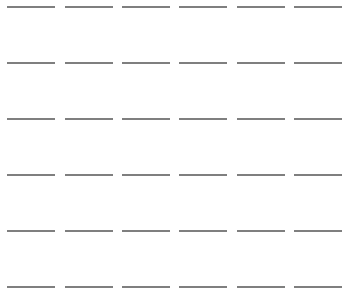

  ERROR    | No former training found ... 
Epochs Progress:   0%|                                                                          | 0/10 [00:00<?, ?it/s]

  INFO     | Training ... 


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[144,604800] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node PartitionedCall_2/gradients/StatefulPartitionedCall_grad/PartitionedCall/gradients/decoder/dense_5/MatMul_grad/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Identity_1/_2]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[144,604800] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node PartitionedCall_2/gradients/StatefulPartitionedCall_grad/PartitionedCall/gradients/decoder/dense_5/MatMul_grad/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_train_step_8279]

Function call stack:
distributed_train_step -> distributed_train_step


In [28]:
ae.fit(
    train_dataset=train_ds, 
    test_dataset=test_ds,
    instance_name='episode',
    instance_scale=1,
    epochs=10,
    learning_rate=1e-3,
    random_latent=random_latent,
    latent_dim=LATENT_DIM ,
    recoding_dir=recoding_dir,
    gray_plot=True,
    generate_epoch=5,
    save_epoch=5
)